# Simple logistic model with uncertainty
We want
- Logistic regression 
- LASSO/Ridge regularization
- Uncertainty quantification and prior-ification

## Model
Let $Y_{it}$ be the Republican _score_, defined as the proportion of votes Republican received over the total votes received by Republican and Democratic candidates. Let $W_{it}$ be whether the Republican wins.

Assume that 
$$
Y_{it} \sim \mathcal{N}(X\beta, \sigma^2)
$$
We infer $\beta$ via a penalized logistic regression with cross-validation selection of the penalities. We infer $\sigma^2$ by simply taking the variance of the prediction errors.

On the test set, assume that polls are drawn from $\text{Bin}(n, Y) \approx \mathcal{N}(nY, nY(1-Y))$. This is a normal likelihood with normal prior Bayesian model, and the posterior is easy to compute.

In [1]:
import us
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm

In [2]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
# import geopandas as gpd
sns.set_style('white')
plt.rcParams['figure.dpi'] = 150

In [3]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, ElasticNetCV

In [4]:
df = feather.read_dataframe('data/final_merged.feather').drop_duplicates()
df['raceyear'] = df['year']

In [5]:
trends = pd.read_csv('data/google_trends_3.csv').iloc[:,2:].drop_duplicates().rename(columns={'year' : 'raceyear'})

In [6]:
trends = (trends.groupby(['raceyear', 'district', 'state_fips']).mean()
          .reset_index()
          .assign(
              rep_to_tot_nov=lambda x : x['rep_cand_nov'] / (x['dem_cand_nov'] + x['rep_cand_nov']),
              rep_to_tot_oct=lambda x : x['rep_cand_oct'] / (x['dem_cand_oct'] + x['rep_cand_oct']),
          ))

In [7]:
df = (df.merge(trends[['raceyear', 'district', 'state_fips', 'rep_cand_nov', 
                       'dem_cand_nov','rep_to_tot_nov', 'rep_to_tot_oct']], how='left',))

In [8]:
cols = ['rep_incumbent', 'dem_incumbent', 'dem_is_female', 'rep_is_female',
       'dem_percent', 'minority_percentage', 'pres_approval', 'same_as_pres_party_rep',
       'same_as_pres_party_dem', 'log_med_income', 'percent_bachelor_or_above',
        'rep_to_tot_oct', 'rep_to_tot_nov']
#        'rep_cand_oct', #'rep_cand_nov', 
#         'dem_cand_oct', #'dem_cand_nov', 'rep_to_tot_nov', 
#         'rep_to_tot_oct']

for year in df['raceyear'].unique():
    df.loc[df['raceyear'] == year, cols] = (df.loc[df['raceyear'] == year, cols]
                                        .fillna(df.loc[df['raceyear'] == year, cols]
                                                .mean()))

In [9]:
state = pd.get_dummies(df['state']).iloc[:,:-1]

In [10]:
df = pd.concat([df, state], axis=1, sort=False)

In [11]:
# fill na stuff
not_failing = (df[cols].isnull().sum(axis=1) <= 3) & (df['raceyear'] < 2018)
df.loc[not_failing, cols] = df.loc[not_failing, cols].fillna(df.loc[not_failing, cols].mean())

In [12]:
non_dummies = ['rep_score'] + cols
covariate_cols = non_dummies + list(state.columns)
x_cols = covariate_cols[1:]

In [13]:
interaction = []
for i, x1 in enumerate(x_cols):
    for x2 in x_cols[i:]:
        col1 = df[x1].astype(float) 
        col2 = df[x2].astype(float)
        interact = col1 * col2
        
        # Prevent simple collinearity
        if (interact != col1).any() and  (interact != col2).any() and (interact != 0).any():
            df[f'{x1}_x_{x2}'] = interact
            interaction.append(f'{x1}_x_{x2}')

In [14]:
data = df[['raceyear'] + covariate_cols + interaction].copy().astype(float)

In [15]:
train = data.query('raceyear < 2018').drop('raceyear', axis=1).dropna().drop_duplicates()
test = data.query('raceyear == 2018').drop('raceyear', axis=1)

In [16]:
# we don't predict uncontested races
uncontest = df.query('raceyear==2018')
uncontest_index = uncontest[uncontest['dem_uncontested'] | uncontest['rep_uncontested']].index
test_contest = test[~test.index.isin(uncontest_index)].copy()
test_uncontest = test[test.index.isin(uncontest_index)].copy()

In [17]:
# info := basic identifiers of district
test_info = df.loc[test_contest.index, ['state', 'state_fips','district','fivethirtyeight_district']].copy()
train_info = df.loc[train.index, ['state', 'state_fips','district', 'raceyear','total_votes']].copy()

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
# weigh election results by number of votes, CLT
# w = (train_info['total_votes'].fillna(train_info['total_votes'].mean())) ** .5
# w /= w.sum()

In [19]:
y = train['rep_score']
X = train.loc[:, 'rep_incumbent':].astype(float)

In [20]:
foldid = np.random.choice(list(range(10)), size=len(X))

model = ElasticNetCV(l1_ratio=np.linspace(0.1, 1, 10), n_alphas=50,
                   fit_intercept=True, normalize=True, cv=10,
                   copy_X=True, n_jobs=2)

model.fit(X, y)
# fit = cvglmnet(x=X.values.copy(), y=y.values.copy(), nlambda=20,
#                weights=w.values.copy(),
#                alpha=.9, family='gaussian', foldid=foldid)

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. 

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
       max_iter=1000, n_alphas=50, n_jobs=2, normalize=True,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [22]:
coefs = pd.Series(model.coef_, index=X.columns)
nonzero_coefs = coefs[coefs != 0]
nonzero_coefs[nonzero_coefs.abs().argsort()].to_frame().style.background_gradient()

,0
same_as_pres_party_dem_x_Missouri,0.000161861
dem_is_female_x_Indiana,-0.000333265
rep_is_female_x_West Virginia,0.000394752
rep_incumbent_x_Washington,0.000780849
dem_is_female_x_rep_to_tot_oct,-0.000845664
log_med_income_x_Iowa,-0.000920438
rep_incumbent_x_Wisconsin,0.000987455
log_med_income_x_Texas,-0.00104062
dem_incumbent_x_Vermont,-0.00105389
pres_approval_x_Illinois,-0.00150941


In [23]:
model.predict(X).shape

(1530,)

In [24]:
predict = model.predict(X)
train_info['residual_sq'] = (train['rep_score'] - predict) ** 2
train_info['residual'] = (train['rep_score'] - predict)


In [25]:
emp_cov = train_info.pivot_table(index=['state','district'], columns='raceyear', values='residual').T.corr().fillna(0)

In [26]:
# state_cov_matrix = (train_info.groupby(['state_fips', 'district', 'raceyear'])['residual']
#                     .mean().unstack('raceyear').T.corr())
# for i in (range(len(state_cov_matrix))):
#     state_cov_matrix.iloc[i, i] = np.nan
# state_cov_matrix = state_cov_matrix.groupby('state_fips').mean().T.groupby('state_fips').mean()

In [27]:
# state_cov_matrix = state_cov_matrix.fillna(0)

In [28]:
res = train['rep_score'] - predict
res_normal = ((res - res.mean()) / res.std()).values

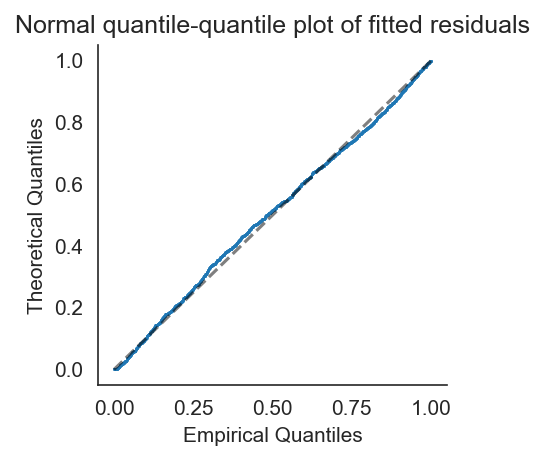

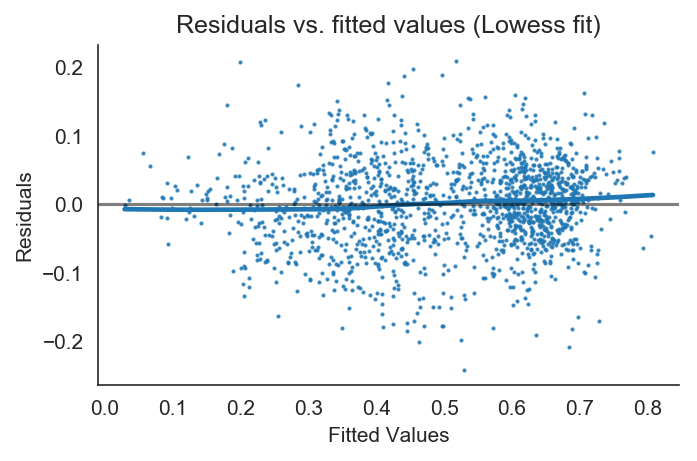

In [29]:
plt.figure(figsize=(3,3))
plt.scatter(ECDF(res_normal)(res_normal), norm.cdf(res_normal), marker='.', s=.5, alpha=1)
plt.plot([0,1],[0,1], 'k--', alpha=.5)
plt.xlabel('Empirical Quantiles')
plt.ylabel('Theoretical Quantiles')
plt.title('Normal quantile-quantile plot of fitted residuals')
sns.despine()
plt.savefig('report/qq.pdf', bbox_inches='tight')

plt.figure(figsize=(5,3))
sns.regplot(predict, res, lowess=True, scatter_kws={'s':1})
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.title('Residuals vs. fitted values (Lowess fit)')
plt.axhline(0, color='k', alpha=.5)
sns.despine()
plt.savefig('report/diagnostics.pdf', bbox_inches='tight')

In [30]:
# Generate mu0 and sigma0 for the test set
mu_0 = model.predict(test_contest.loc[:, 'rep_incumbent':].values)
sigma2_0 = train_info.groupby('state')['residual_sq'].mean()
test_info['sigma2_0'] = test_info['state'].apply(lambda x: sigma2_0[x])
sigma2_0 = test_info['sigma2_0'][test_contest.index]
Sigma_0 = np.diag(sigma2_0.values)

# s_d = test_info.loc[test_contest.index][['state', 'district']]

# for i in tqdm(range(len(Sigma_0))):
#     for j in range(len(Sigma_0)):
#         if i != j:
#             (st, dis) = s_d.iloc[i]
#             (st2, dis2) = s_d.iloc[j]
#             Sigma_0[i, j] = emp_cov.loc[(st, dis), (st2, dis2)] * Sigma_0[i,i] * Sigma_0[j,j]
            

In [31]:
mu_0.mean()

0.4954233365527225

# First update - Generic ballot

In [32]:
generic_ballot = (pd.read_csv('https://projects.fivethirtyeight.com/generic-ballot-data/generic_ballot.csv')
                  .sort_values('date', ascending=False))
generic_ballot = generic_ballot.iloc[0]
z_thresh = 1.644854
sigma2_G = ((generic_ballot['rep_hi']/100 - generic_ballot['rep_lo']/100) / 2 / z_thresh) ** 2

In [33]:
gen_ballot = feather.read_dataframe('generic_ballot.feather')
gen_ballot = gen_ballot[gen_ballot['created_at'] >= '2018-10-15'].copy()

In [34]:
def normal_conditioning(mu0, mu1, v0, v1, v01, observed):
    new_mu = mu0 + v01 @ np.linalg.inv(v1) @ (observed - mu1)
    new_v = v0 - v01 @ np.linalg.inv(v1) @ v01.T
    return new_mu, new_v

mu_after_gen, sigma_after_gen = mu_0, Sigma_0
for _, x in tqdm(gen_ballot.iterrows()):
    n = len(Sigma_0)
    observed = x['rep_score']
    observed = np.array([observed])
    mu1 = np.array([mu_after_gen.mean()])
    v1 = np.array([[1/(4 * x['sampleSize']) + sigma2_G + Sigma_0.sum() / (n ** 2)]])
    v01 = (sigma_after_gen / n @ np.ones(n))[:, np.newaxis]
    mu_after_gen, sigma_after_gen = normal_conditioning(mu_after_gen, mu1, sigma_after_gen, v1, v01, observed)

In [35]:
mu_after_gen.mean()

0.4830548088623603

# Second update - Polls

In [36]:
polls = feather.read_dataframe('polls.feather')
sigma2_poll = polls.groupby(['state', 'fivethirtyeight_district'])['rep_score'].std() ** 2
sigma2_poll = sigma2_poll.fillna(sigma2_poll.mean()).reset_index()
sigma2_poll.columns = ['state','fivethirtyeight_district','sigma2_poll']
polls = polls.merge(sigma2_poll)

In [37]:
polls = (test_info.reset_index()
         .merge(polls, how='left').dropna()
         .sort_values('created_at').groupby('index')
         .apply(lambda x: x.iloc[-3:])
         .reset_index(drop=True).drop(['sigma2_0','id','created_at'], axis=1))

In [38]:
def update_poll(poll, mu, Sigma):
    m = pd.Series(mu, index=test_contest.index)
    ind = poll['index']
    mu1 = np.array([m[ind]])
    ej = pd.Series(np.zeros(len(test_contest)), 
                  index=test_contest.index)
    ej[ind] = 1
    ej = ej.values
    cov = (Sigma @ ej)[:, np.newaxis]
    v1 = np.array([[1/4/poll['sampleSize'] + poll['sigma2_poll'] + ej.dot(Sigma @ ej)]])
    observation = poll['rep_score']
    
    return normal_conditioning(mu, mu1, Sigma, v1, cov, observation)

In [39]:
mu, Sigma = mu_after_gen.copy(), sigma_after_gen.copy()

In [40]:
mu.mean()

0.4830548088623603

In [41]:
for _, poll in tqdm(polls.iterrows()):
    mu, Sigma = update_poll(poll, mu, Sigma)

Probability of Democratic House for Prior = 0.17425999999999997
Probability of Democratic House for Posterior after generic ballot = 0.86502
Probability of Democratic House for Posterior = 0.94348


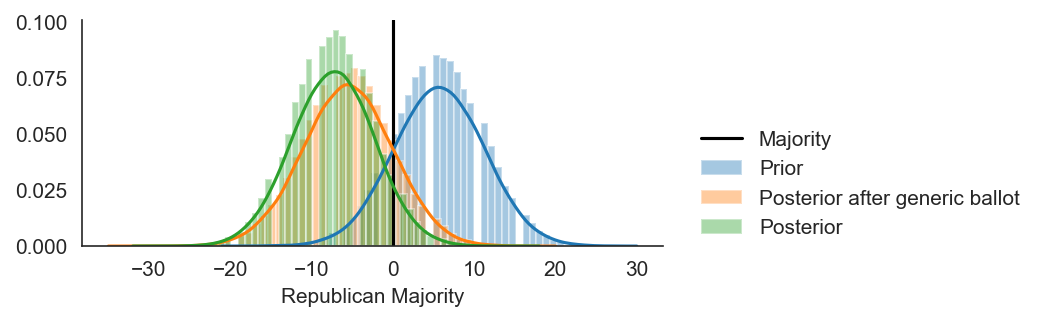

In [42]:
rep_uncon = df.query('raceyear==2018')['rep_uncontested'].sum()

plt.figure(figsize=(5,2))
plt.axvline(0, color='k', label='Majority')

for (lab, mu_, Sigma_) in [['Prior', mu_0, Sigma_0], ['Posterior after generic ballot', mu_after_gen, sigma_after_gen], 
                           ['Posterior', mu, Sigma]]:
    sim = np.random.multivariate_normal(mu_, Sigma_, size=50000)
    sns.distplot((sim > .5).sum(axis=1) + rep_uncon - 217, bins=53,
                 kde_kws={'bw':1}, label=lab)
    print(f'Probability of Democratic House for {lab} = {1-((sim > .5).sum(axis=1) + 3 > 217.5).mean()}')
plt.xlabel('Republican Majority')
sns.despine()
plt.legend(frameon=False, loc=(1.05,0))
plt.savefig('report/rep_seats_with_diagonal_prior.pdf', bbox_inches='tight')

In [205]:
1-((sim > .5).sum(axis=1) + 3 > 217.5).mean()

0.97662

In [ ]:
(sim > .5).sum(axis=1).std()

In [ ]:
test_info['mu'] = mu
test_info['sigma'] = np.diag(Sigma) ** .5

In [ ]:
test_info['edge'] = (test_info['mu'] - .5) / test_info['sigma']

In [ ]:
maps = gpd.read_file('data/kx-us-116th-congressional-districts-SHP (1)/us-116th-congressional-districts.shp')

In [ ]:
def wrapper(func, x):
    try:
        return func(x)
    except:
        return None

In [ ]:
maps['state_fips'] = maps['GEOID'].apply(lambda x : int(x[:2]))
maps['district'] = maps['GEOID'].apply(lambda x : wrapper(int, x[2:]))

In [ ]:
maps = maps[['state_fips', 'district', 'geometry']].copy()

In [ ]:
uncon = df.loc[test_uncontest.index, ['state_fips', 'district', 'rep_uncontested']].copy()

In [ ]:
uncon['mu'] = uncon['rep_uncontested'].astype(float)

In [ ]:
uncon['sigma'] = 0
uncon['edge'] = (uncon['mu'] - .5) * 40

In [ ]:
preds = pd.concat([test_info, uncon.drop('rep_uncontested', axis=1)], sort=False)

In [ ]:
final_map = maps.merge(preds, how='right', on=['state_fips', 'district'])

In [ ]:
f, ax = plt.subplots(1, figsize=(7, 5))
final_map.query('state not in ["Alaska", "Hawaii"]')[['geometry', 'mu']]\
.plot('mu', cmap='coolwarm', vmin=0.3, vmax=.7, 
      linewidth=0, figsize=(5,5), ax=ax)

ax.set_aspect(aspect=1.3)
ax.axis('off')

# plt.savefig('report/projected_map.eps')

# Produce a table of predictions

In [ ]:
preds['state'] = preds['state_fips'].apply(lambda x: us.states.lookup(str(x).zfill(2)).name)

In [ ]:
from scipy.stats import norm

In [ ]:
def compute_prob_republican(x):
    if x['sigma'] == 0:
        return x['mu']
    else:
        return 1 - norm.cdf((.5 - x['mu']) / x['sigma'])

In [ ]:
preds['republican_win_prob'] = preds.apply(compute_prob_republican, axis=1)

In [ ]:
preds = preds.merge(df.query('raceyear == 2018')[['state_fips', 'district', 'rep_lastname', 'dem_lastname']])

In [ ]:
preds['projected_winning_candidate'] = preds.apply(lambda x : x['rep_lastname']  + ' (R)'
                                                   if x['republican_win_prob'] > .5 
                                                   else x['dem_lastname'] + ' (D)', axis=1)


In [ ]:
preds['winner_prob'] = np.maximum(preds['republican_win_prob'], 1-preds['republican_win_prob'])

In [ ]:
preds['cong_district'] = preds['state'].astype(str) + '-' + preds['district'].astype(str).str.zfill(2)

In [ ]:
winners = preds.sort_values(['state', 'district'])[['cong_district', 'projected_winning_candidate', 'winner_prob']].copy()
winners.columns = ['District', 'Projected Winner', 'Probability']

In [ ]:
with open('report/projected_results.tex', 'w') as f:
    f.write(winners.to_latex(index=False, longtable=True))

In [ ]:
winners.to_csv('report/projections.csv', index=False)